In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/DS:Deep Learning in Python/facial expression recognition')

In [2]:
from __future__ import print_function, division
from builtins import range

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

from util import getImagedata, error_rate, init_weight_and_bias, y2indicator
from ANN_tf import HiddenLayer

In [0]:
def init_filter(shape, poolsz):
    shape = np.array(shape)
    poolsz = np.array(poolsz)
    #w = np.random.randn(*shape) * np.sqrt(2) / np.sqrt(np.prod(shape[:-1]) + shape[:-1] * np.prod((shape[:-2]/np.prod(poolsz))))
    w = np.random.randn(*shape) * np.sqrt(2) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2] / np.prod(poolsz)))
    return w.astype(np.float32)

class ConvPoolLayer(object):
    def __init__(self, mi, mo, fw=5, fh=5, poolsz = (2, 2)):
        #mi = input feature map size
        #mo = output feature map size
        sz = (fw, fh, mi, mo)
        W0 = init_filter(sz, poolsz)
        self.W = tf.Variable(W0)
        b0 = np.zeros(mo, dtype=np.float32)
        self.b  = tf.Variable(b0)
        self.poolsz = poolsz
        self.params = [self.W, self.b]

    def forward(self, X):
        conv_out = tf.nn.conv2d(X, self.W, strides=[1,1,1,1], padding='SAME')
        conv_out = tf.nn.bias_add(conv_out, self.b)
        p1, p2 = self.poolsz
        pool_out = tf.nn.max_pool(
            conv_out,
            ksize = [1, p1, p2, 1],
            strides = [1, p1, p2, 1],
            padding = 'SAME'
        )

        return tf.nn.relu(pool_out)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
i: 0 j: 0, nb: 1303, cost: 2.3503997325897217, error rate: 0.813
i: 0 j: 20, nb: 1303, cost: 2.3385887145996094, error rate: 0.74
i: 0 j: 40, nb: 1303, cost: 2.330146551132202, error rate: 0.74
i: 0 j: 60, nb: 1303, cost: 2.29823899269104, error rate: 0.74
i: 0 j: 80, nb: 1303, cost: 2.325718402862549, error rate: 0.74
i: 0 j: 100, nb: 1303, cost: 2.3159570693969727, error rate: 0.74
i: 0 j: 120, nb: 1303, cost: 2.3100569248199463, error rate: 0.74
i: 0 j: 140, nb: 1303, cost: 2.3141794204711914, error rate: 0.74
i: 0 j: 160, nb: 1303, cost: 2.288508176803589, error rate: 0.733
i: 0 j: 180, nb: 1303, cost: 2.260951280593872, error rate: 0.74
i: 0 j: 200, nb: 1303, cost: 2.2622129917

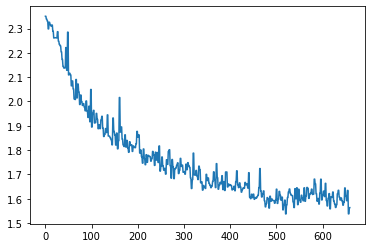

In [4]:
class CNN(object):
    def __init__(self, convpool_layer_sizes, hidden_layer_sizes):
        self.convpool_layer_sizes = convpool_layer_sizes
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, Y, Xvalid, Yvalid, lr=1e-2, mu=0.9, reg=1e-3, decay=0.99999, eps=1e-10, batch_sz=30,  epochs=5, show_fig=True):
        lr = np.float32(lr)
        mu = np.float32(mu)
        reg = np.float32(reg)
        decay = np.float32(decay)
        eps = np.float32(eps)
        K = len(set(Y))

        # prepare a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = y2indicator(Y).astype(np.float32)

        Yvalid = y2indicator(Yvalid).astype(np.float32)
        Yvalid_flat = np.argmax(Yvalid, axis=1) # for calculating error rate

        # initialize convpool layers
        N, width, height, c = X.shape
        mi = c
        outw = width
        outh = height
        self.convpool_layers = []
        for mo, fw, fh in self.convpool_layer_sizes:
            layer = ConvPoolLayer(mi, mo, fw, fh)
            self.convpool_layers.append(layer)
            outw = outw // 2
            outh = outh // 2
            mi = mo

        # initialize mlp layers
        self.hidden_layers = []
        M1 = self.convpool_layer_sizes[-1][0]*outw*outh #size must be same as output of last convpool layer
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)  
            M1 = M2
            count += 1

         #logistic regression layer
        W, b = init_weight_and_bias(M1, K)
        self.W = tf.Variable(W, 'W_logreg')
        self.b = tf.Variable(b, 'b_logreg')

        # collect params for later use        
        self.params = [self.W, self.b]
        for h in self.convpool_layers:
            self.params += h.params
        for h in self.hidden_layers:
            self.params += h.params

        #set up tensorflow functions and variables
        tfX = tf.placeholder(tf.float32, shape=(None, width, height, c), name='X')
        tfY = tf.placeholder(tf.float32, shape= (None, K), name='Y')
        act = self.forward(tfX)

        rcost = reg*sum([tf.nn.l2_loss(p) for p in self.params])
        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=act,
                labels=tfY
            )
        ) + rcost

        prediction = self.predict(tfX)

        train_op = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=mu).minimize(cost)

        n_batches = N // batch_sz
        costs = []
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                X, Y  = shuffle(X, Y)
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                    Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                    session.run(train_op, feed_dict={tfX: Xbatch, tfY: Ybatch})

                    if j % 20 == 0:
                        c = session.run(cost, feed_dict={tfX: Xvalid, tfY: Yvalid})
                        costs.append(c)

                        p = session.run(prediction, feed_dict={tfX:Xvalid, tfY:Yvalid})
                        costs.append(c)

                        p = session.run(prediction, feed_dict= {tfX:Xvalid, tfY:Yvalid})
                        e = error_rate(Yvalid_flat, p)
                        print(f"i: {i} j: {j}, nb: {n_batches}, cost: {c}, error rate: {e}")

        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward(self, X):
        Z = X
        for c in self.convpool_layers:
            Z = c.forward(Z)
        Z_shape = Z.get_shape().as_list()
        Z = tf.reshape(Z, [-1, np.prod(Z_shape[1:])])
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return tf.matmul(Z, self.W) + self.b

    def predict(self, X):
        pY = self.forward(X)
        return tf.argmax(pY, 1)


def main():
    Xtrain, Ytrain, Xvalid, Yvalid = getImagedata()

    #reshape X for tf: N x H x W x C
    Xtrain = Xtrain.transpose((0, 2, 3, 1))
    Xvalid = Xvalid.transpose((0, 2, 3, 1))

    model = CNN(
        convpool_layer_sizes=[(20, 5, 5), (20, 5, 5)],
        hidden_layer_sizes = [500, 300]
    )
    model.fit(Xtrain, Ytrain, Xvalid, Yvalid)

if __name__ == '__main__':
    main()
